In [165]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

In [166]:
df_tweet_fr = pd.read_pickle('../../data/final/sondage_emotion.p')
#df_tweet_fr_test = pd.read_pickle('../data/final/NotIot_FR_tweets_test.p')

#frames = [df_tweet_fr_train, df_tweet_fr_test]

#df_tweet_fr = pd.concat(frames)

#df_tweet_fr.columns = ['text', 'emotion']
df_tweet_fr


,sentiment,text
0,PLAISIR,"c'est d'abord un sentiment de curiosité, d'étude. Evaluer si ces capteurs sont utiles ou non ."
1,ENNUI,"Ils sont présents, ne me gênent pas plus que ça; je ne peux rien y faire donc bon...."
10,PLAISIR,"Dans la mesure ou sur la base d'une analyse en ACV, le système est plus performant, j'y vois un avantage. Cependant, les systèmes intelligents risquent d'une part de rendre plus dépendant les utilisateurs et un comportement moins intelligent."
11,APAISEMENT,"L'IoT dans la vie quotidienne me permet de ressentir une certaine forme de contrôle sur les choses, ce qui est apaisant, serein."
12,PEUR,"Je suis intéressée par les bénéfices que peuvent apporter les dispositifs IoT, mais également inquiète de ce qui pourrait en être tiré s'ils sont détournés de leur objectif primaire."
16,APAISEMENT,L’Internet des Objets réconcilie le monde numérique et virtuel crée par les réseaux informatique et les applications mobiles avec le monde physique.
17,APAISEMENT,"Projette dans le futur, laisse imaginer toutes les améliorations possibles pour les usagers et pour la planète."
19,PLAISIR,J'aime la modernité.
20,APAISEMENT,Je pense que l'usage des dispositifs IoT dans la vie quotidienne permet une plus grande sérénité que ce soit pour l'écologie et la sécurité.
25,PLAISIR,"l'IoT nous permettra d'adopter un comportement plus écocitoyen, avec un peu de compétition, pour campus plus vert."


In [167]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    def space_uderscore(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        #return re.sub(r':([a-z&]+)_([a-z&]+):', r'\1\2', input_text)
        return input_text.replace('_',' ')
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(self.space_uderscore).apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [168]:
textcount = TextCounts()
#get text features from train dataset
df_eda = textcount.fit_transform(df_tweet_fr.text)
df_eda['sentiment'] = df_tweet_fr.sentiment
df_eda['origin_text'] = df_tweet_fr.text

In [169]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
            count       mean        std   min    25%   50%    75%    max
sentiment                                                               
AMOUR       5.0    11.400000  5.683309   4.0   7.00   13.0  16.00  17.0 
APAISEMENT  25.0   28.800000  24.762202  2.0   15.00  23.0  36.00  105.0
COLERE      1.0    30.000000 NaN         30.0  30.00  30.0  30.00  30.0 
ENNUI       3.0    21.666667  7.234178   17.0  17.50  18.0  24.00  30.0 
MEPRIS      2.0    43.000000  41.012193  14.0  28.50  43.0  57.50  72.0 
PEUR        14.0   19.428571  19.551566  0.0   3.25   19.5  26.75  75.0 
PLAISIR     40.0   24.025000  23.307848  0.0   8.75   16.5  35.50  107.0
SURPRISE    10.0   27.800000  34.778026  6.0   12.00  18.0  24.75  124.0


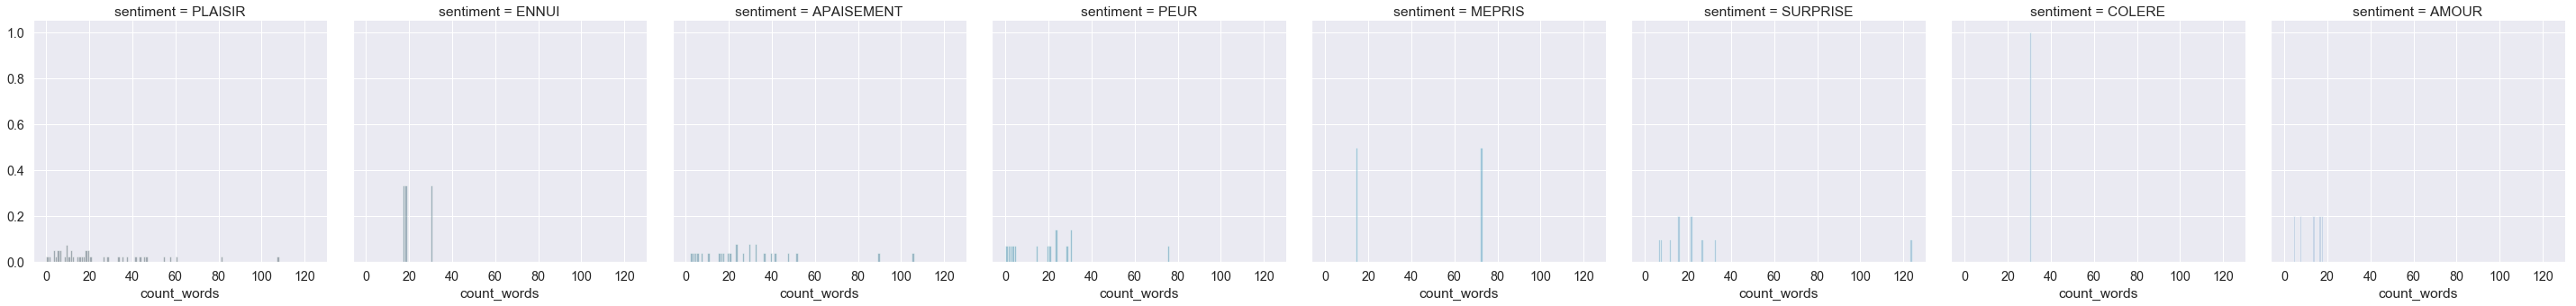

In [170]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
AMOUR       5.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
APAISEMENT  25.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
COLERE      1.0    0.0  NaN   0.0  0.0  0.0  0.0  0.0
ENNUI       3.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
MEPRIS      2.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
PEUR        14.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
PLAISIR     40.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
SURPRISE    10.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0


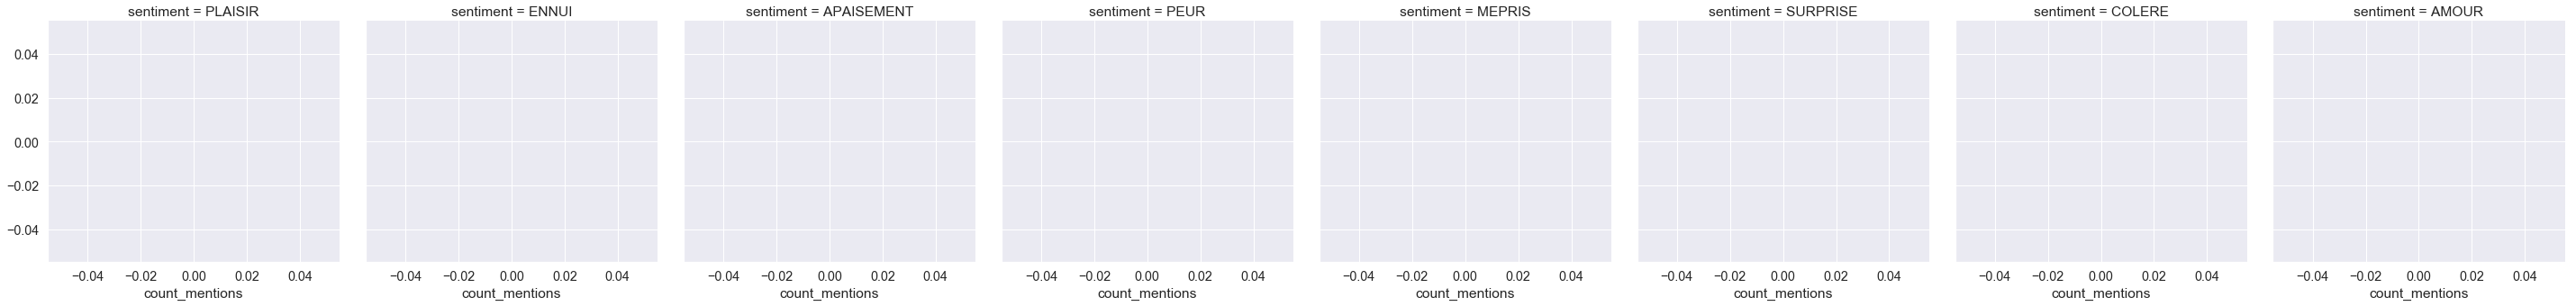

In [171]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
AMOUR       5.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
APAISEMENT  25.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
COLERE      1.0    0.0  NaN   0.0  0.0  0.0  0.0  0.0
ENNUI       3.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
MEPRIS      2.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
PEUR        14.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
PLAISIR     40.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
SURPRISE    10.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0


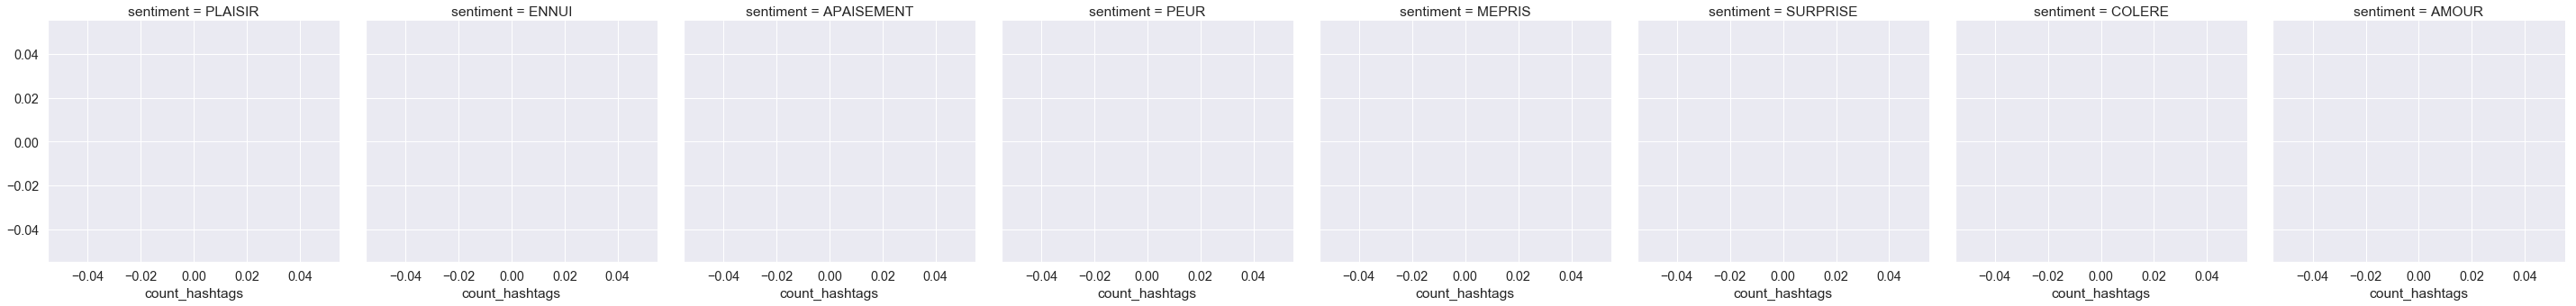

In [172]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
            count  mean       std  min   25%  50%   75%  max
sentiment                                                   
AMOUR       5.0    0.00  0.000000  0.0  0.00  0.0  0.00  0.0
APAISEMENT  25.0   0.08  0.400000  0.0  0.00  0.0  0.00  2.0
COLERE      1.0    0.00 NaN        0.0  0.00  0.0  0.00  0.0
ENNUI       3.0    0.00  0.000000  0.0  0.00  0.0  0.00  0.0
MEPRIS      2.0    0.50  0.707107  0.0  0.25  0.5  0.75  1.0
PEUR        14.0   0.00  0.000000  0.0  0.00  0.0  0.00  0.0
PLAISIR     40.0   0.05  0.220721  0.0  0.00  0.0  0.00  1.0
SURPRISE    10.0   0.00  0.000000  0.0  0.00  0.0  0.00  0.0


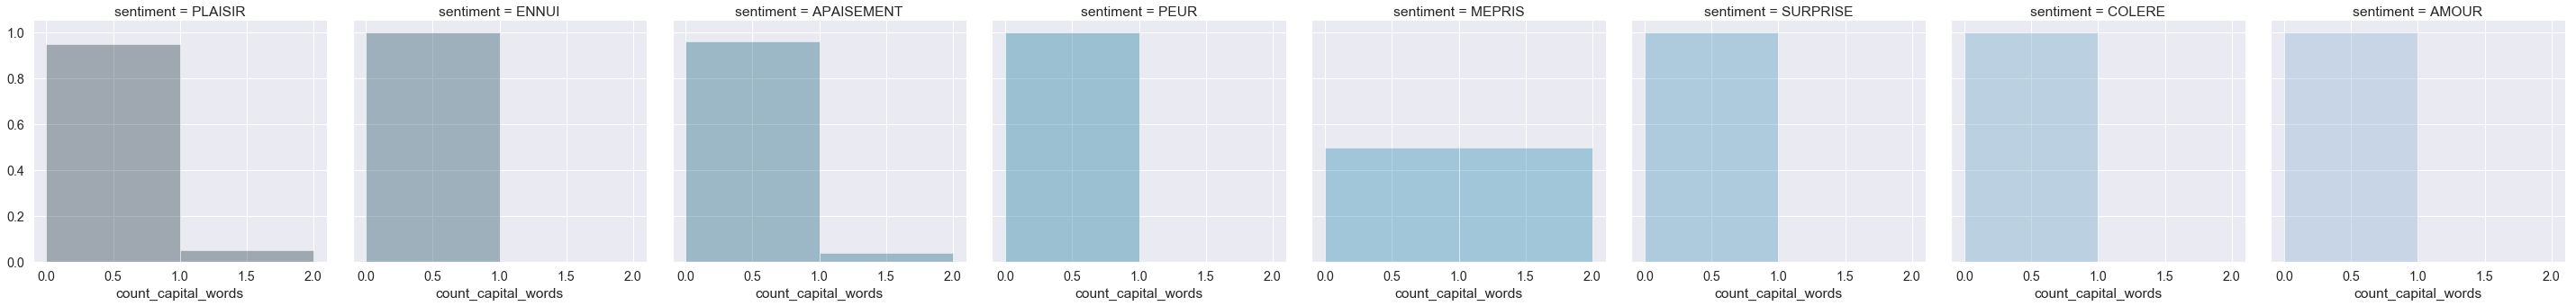

In [173]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min   25%  50%   75%  max
sentiment                                                       
AMOUR       5.0    0.000000  0.000000  0.0  0.00  0.0  0.00  0.0
APAISEMENT  25.0   0.080000  0.276887  0.0  0.00  0.0  0.00  1.0
COLERE      1.0    0.000000 NaN        0.0  0.00  0.0  0.00  0.0
ENNUI       3.0    0.333333  0.577350  0.0  0.00  0.0  0.50  1.0
MEPRIS      2.0    0.500000  0.707107  0.0  0.25  0.5  0.75  1.0
PEUR        14.0   0.214286  0.578934  0.0  0.00  0.0  0.00  2.0
PLAISIR     40.0   0.025000  0.158114  0.0  0.00  0.0  0.00  1.0
SURPRISE    10.0   0.000000  0.000000  0.0  0.00  0.0  0.00  0.0


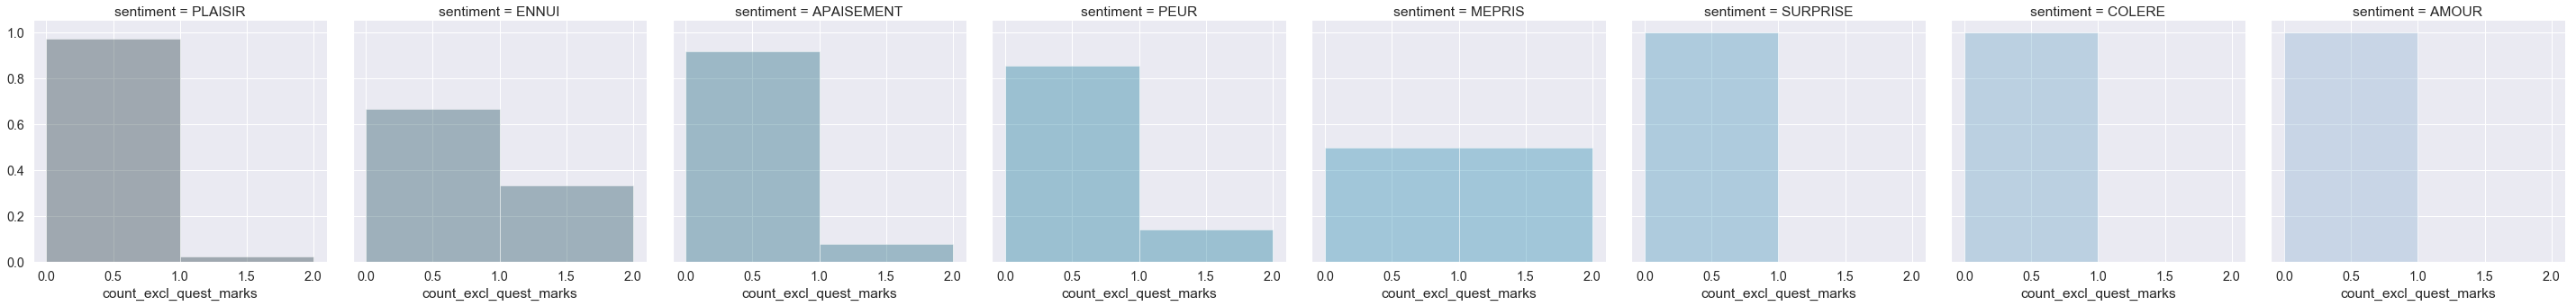

In [174]:
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
AMOUR       5.0    0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
APAISEMENT  25.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
COLERE      1.0    0.000000 NaN        0.0  0.0  0.0  0.0  0.0
ENNUI       3.0    0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
MEPRIS      2.0    0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
PEUR        14.0   0.142857  0.534522  0.0  0.0  0.0  0.0  2.0
PLAISIR     40.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
SURPRISE    10.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


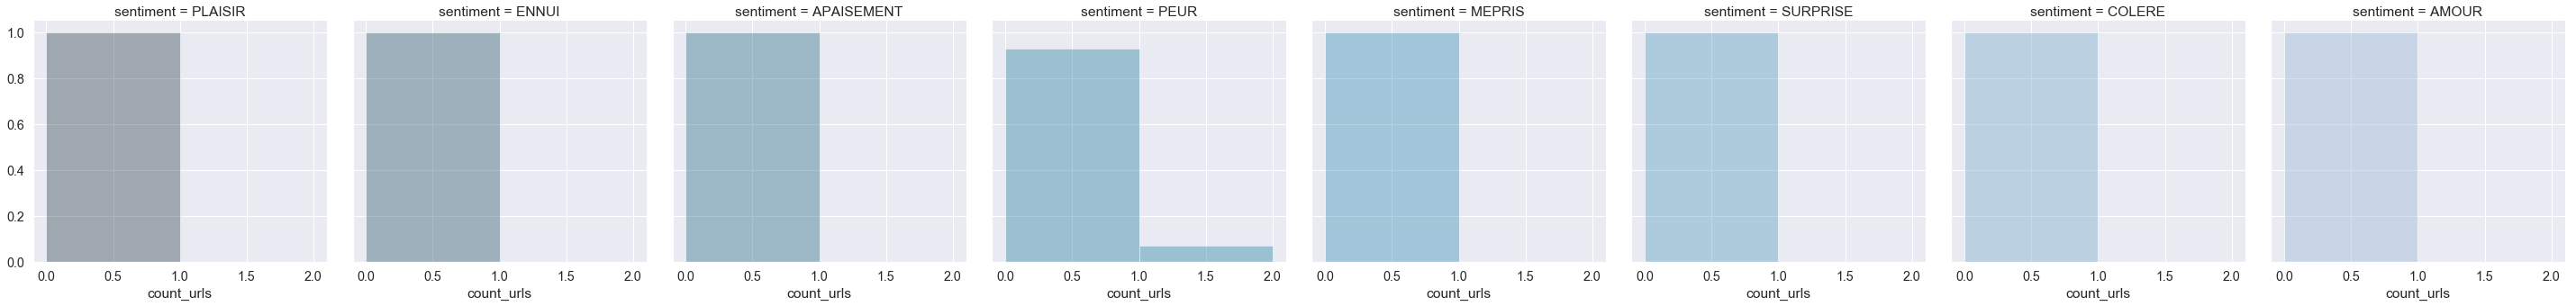

In [175]:
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
AMOUR       5.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
APAISEMENT  25.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
COLERE      1.0    0.0  NaN   0.0  0.0  0.0  0.0  0.0
ENNUI       3.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
MEPRIS      2.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
PEUR        14.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
PLAISIR     40.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
SURPRISE    10.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0


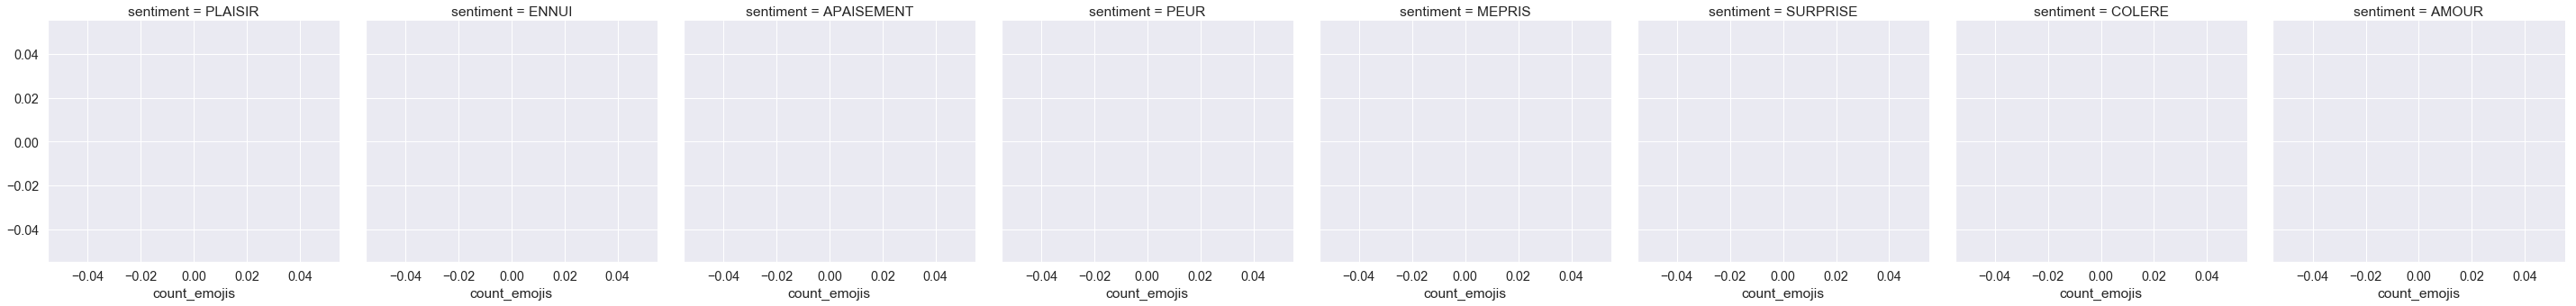

In [176]:
show_dist(df_eda, 'count_emojis')

In [177]:
class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    #def remove_hashtags(self, input_text):
        #return re.sub(r'#\w+', '', input_text)    
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_demojize(self, input_text):
        #demojize all emojis 
        return emoji.demojize(input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        #return re.sub(r':([a-z&]+)_([a-z&]+):', r'\1\2', input_text)
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def replace_acronyms(self, input_text):
        acronyms_dic = {
            "omg":"oh mon dieu",
            "mdr":"mort de rire"}
        acronyms_pattern = re.compile(r'\b(' + '|'.join(acronyms_dic.keys()) + r')\b')
        return acronyms_pattern.sub(lambda x: acronyms_dic[x.group()], input_text)
        
    def stopwords_spell(self, input_text):
        stopwords_list = stopwords.words('French')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["ne", "pas","n'","plus","jamais","non","oui"]
        blacklist = ["rt",'http','les','co','via']
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and (word not in blacklist) and len(word) > 1] 
        #correct words
        #spell = SpellChecker()
        correct_words = [word for word in clean_words]
        return " ".join(correct_words) 
    
    def lemmatizing(self,input_text):
        lemmatizer = FrenchLefffLemmatizer()
        words = input_text.split() 
        lemmed_words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmed_words)
    
    def stemming(self, input_text):
        stemmer = FrenchStemmer()
        words = input_text.split() 
        stemmed_words = [stemmer.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_demojize).apply(self.emoji_oneword).apply(self.replace_acronyms).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.replace_acronyms).apply(self.stopwords_spell)
        #print(clean_X)
        return clean_X

In [178]:
#clean train dataset
cleantext = CleanText()
sr_clean = cleantext.fit_transform(df_tweet_fr.text)
sr_clean

0      abord sentiment curiosité étude evaluer si capteurs utiles non                                                                                                                                                                                                                                                                                                                                                                                                                                         
1      ils présents ne gênent pas plus ça ne peux rien faire donc bon                                                                                                                                                                                                                                                                                                                                                                                                                                         
10     mes

In [179]:
for k,v in word_freq.items():
    if k=="écologie": print(v)

1


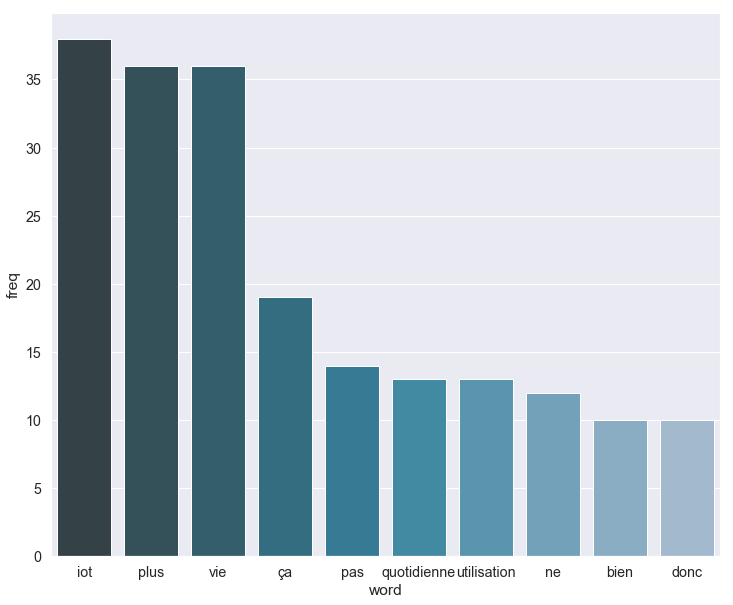

In [180]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

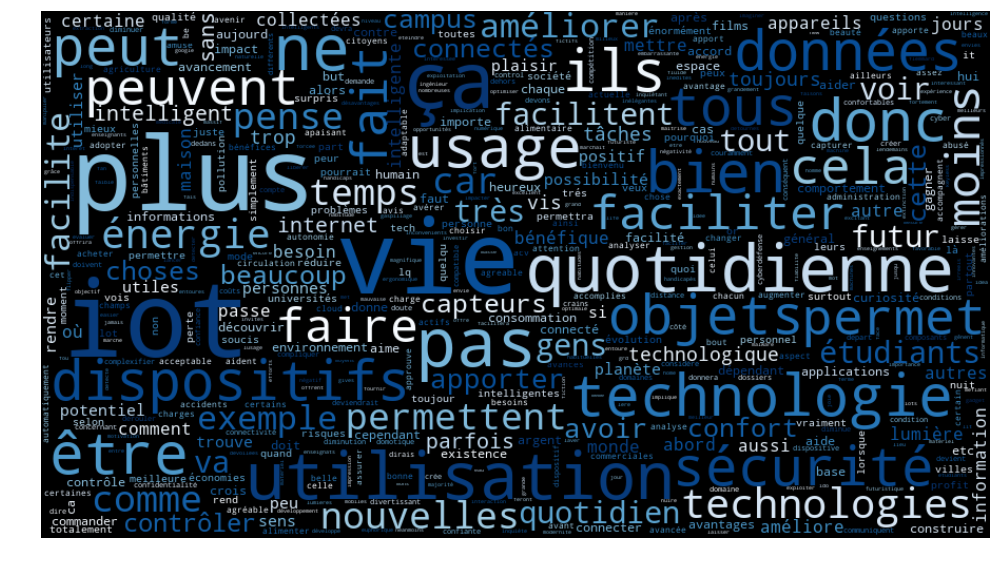

In [181]:
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(word_counter)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [182]:
df_model_fr = df_eda
df_model_fr['clean_text'] = sr_clean
df_model_fr = df_model_fr.drop_duplicates('clean_text')

In [183]:
df_model_fr

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment,origin_text,clean_text
0,18,0,0,0,0,0,0,PLAISIR,"c'est d'abord un sentiment de curiosité, d'étude. Evaluer si ces capteurs sont utiles ou non .",abord sentiment curiosité étude evaluer si capteurs utiles non
1,18,0,0,0,0,0,0,ENNUI,"Ils sont présents, ne me gênent pas plus que ça; je ne peux rien y faire donc bon....",ils présents ne gênent pas plus ça ne peux rien faire donc bon
10,41,0,0,1,0,0,0,PLAISIR,"Dans la mesure ou sur la base d'une analyse en ACV, le système est plus performant, j'y vois un avantage. Cependant, les systèmes intelligents risquent d'une part de rendre plus dépendant les utilisateurs et un comportement moins intelligent.",mesure base analyse acv système plus performant vois avantage cependant systèmes intelligents risquent part rendre plus dépendant utilisateurs comportement moins intelligent
11,23,0,0,0,0,0,0,APAISEMENT,"L'IoT dans la vie quotidienne me permet de ressentir une certaine forme de contrôle sur les choses, ce qui est apaisant, serein.",iot vie quotidienne permet ressentir certaine forme contrôle choses apaisant serein
12,30,0,0,0,0,0,0,PEUR,"Je suis intéressée par les bénéfices que peuvent apporter les dispositifs IoT, mais également inquiète de ce qui pourrait en être tiré s'ils sont détournés de leur objectif primaire.",intéressée bénéfices peuvent apporter dispositifs iot également inquiète pourrait être tiré ils détournés objectif primaire
16,23,0,0,0,0,0,0,APAISEMENT,L’Internet des Objets réconcilie le monde numérique et virtuel crée par les réseaux informatique et les applications mobiles avec le monde physique.,l’internet objets réconcilie monde numérique virtuel crée réseaux informatique applications mobiles monde physique
17,17,0,0,0,0,0,0,APAISEMENT,"Projette dans le futur, laisse imaginer toutes les améliorations possibles pour les usagers et pour la planète.",projette futur laisse imaginer toutes améliorations possibles usagers planète
19,4,0,0,0,0,0,0,PLAISIR,J'aime la modernité.,aime modernité
20,26,0,0,0,0,0,0,APAISEMENT,Je pense que l'usage des dispositifs IoT dans la vie quotidienne permet une plus grande sérénité que ce soit pour l'écologie et la sécurité.,pense usage dispositifs iot vie quotidienne permet plus grande sérénité écologie sécurité
25,19,0,0,0,0,0,0,PLAISIR,"l'IoT nous permettra d'adopter un comportement plus écocitoyen, avec un peu de compétition, pour campus plus vert.",iot permettra adopter comportement plus écocitoyen peu compétition campus plus vert


In [184]:
df_model_fr['clean_text'].replace('', np.nan, inplace=True)

In [185]:
df_model_fr = df_model_fr.dropna()
#df_model_fr.head()

In [186]:
df_model_fr
df_model_fr.to_pickle("../../data/final/sondage_emotion_clean.p")

# transform from multi emotion to polarity

In [187]:
df_model = pd.read_pickle('../../data/final/sondage_emotion_clean.p') # save dframe to pickle
df_model.dropna()


,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment,origin_text,clean_text
0,18,0,0,0,0,0,0,PLAISIR,"c'est d'abord un sentiment de curiosité, d'étude. Evaluer si ces capteurs sont utiles ou non .",abord sentiment curiosité étude evaluer si capteurs utiles non
1,18,0,0,0,0,0,0,ENNUI,"Ils sont présents, ne me gênent pas plus que ça; je ne peux rien y faire donc bon....",ils présents ne gênent pas plus ça ne peux rien faire donc bon
10,41,0,0,1,0,0,0,PLAISIR,"Dans la mesure ou sur la base d'une analyse en ACV, le système est plus performant, j'y vois un avantage. Cependant, les systèmes intelligents risquent d'une part de rendre plus dépendant les utilisateurs et un comportement moins intelligent.",mesure base analyse acv système plus performant vois avantage cependant systèmes intelligents risquent part rendre plus dépendant utilisateurs comportement moins intelligent
11,23,0,0,0,0,0,0,APAISEMENT,"L'IoT dans la vie quotidienne me permet de ressentir une certaine forme de contrôle sur les choses, ce qui est apaisant, serein.",iot vie quotidienne permet ressentir certaine forme contrôle choses apaisant serein
12,30,0,0,0,0,0,0,PEUR,"Je suis intéressée par les bénéfices que peuvent apporter les dispositifs IoT, mais également inquiète de ce qui pourrait en être tiré s'ils sont détournés de leur objectif primaire.",intéressée bénéfices peuvent apporter dispositifs iot également inquiète pourrait être tiré ils détournés objectif primaire
16,23,0,0,0,0,0,0,APAISEMENT,L’Internet des Objets réconcilie le monde numérique et virtuel crée par les réseaux informatique et les applications mobiles avec le monde physique.,l’internet objets réconcilie monde numérique virtuel crée réseaux informatique applications mobiles monde physique
17,17,0,0,0,0,0,0,APAISEMENT,"Projette dans le futur, laisse imaginer toutes les améliorations possibles pour les usagers et pour la planète.",projette futur laisse imaginer toutes améliorations possibles usagers planète
19,4,0,0,0,0,0,0,PLAISIR,J'aime la modernité.,aime modernité
20,26,0,0,0,0,0,0,APAISEMENT,Je pense que l'usage des dispositifs IoT dans la vie quotidienne permet une plus grande sérénité que ce soit pour l'écologie et la sécurité.,pense usage dispositifs iot vie quotidienne permet plus grande sérénité écologie sécurité
25,19,0,0,0,0,0,0,PLAISIR,"l'IoT nous permettra d'adopter un comportement plus écocitoyen, avec un peu de compétition, pour campus plus vert.",iot permettra adopter comportement plus écocitoyen peu compétition campus plus vert


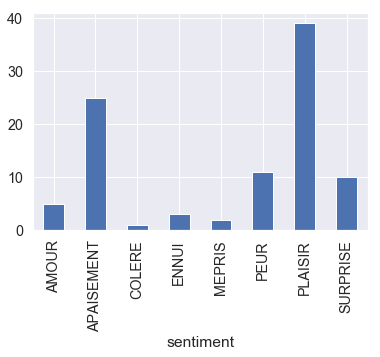

In [188]:
df_model['clean_text'].groupby([df_model.sentiment]).count().plot(kind='bar')


In [162]:
df_model = df_model.replace('colère', 'colère') 
df_model = df_model.replace('peur', 'peur') 
df_model = df_model.replace('tristesse', 'tristesse') 
#df_model = df_model.replace('ENNUI', 'negative') 
#df_model = df_model.replace('INSATISFACTION', 'negative') 
#df_model = df_model.replace('MEPRIS', 'negative') 
#df_model = df_model.replace('PEUR', 'negative') 
#df_model = df_model.replace('TRISTESSE', 'negative') 


#df_model = df_model.replace('joie', 'positive') 
#df_model = df_model.replace('love', 'positive') 
#df_model = df_model.replace('optimism', 'positive') 
#df_model = df_model.replace('surprise', 'positive') 
#df_model = df_model.replace('anticipation', 'positive') 
#df_model = df_model.replace('VALORISATION', 'positive') 

#df_model = df_model.replace('SURPRISE_POSITIVE', 'positive') 
#df_model = df_model.replace('SURPRISE_NEGATIVE', 'negative') 


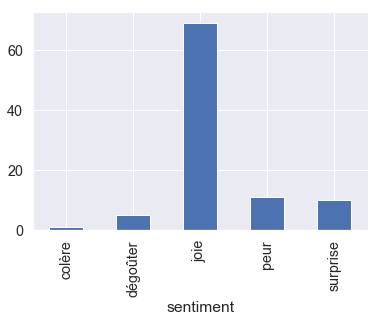

In [163]:
df_model['clean_text'].groupby([df_model.sentiment]).count().plot(kind='bar')


In [164]:
df_model.to_pickle('../../data/final/sondage_polarity_clean.p') # save dframe to pickle